In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
# Parameters
alpha_init = 1 / 10  # 1/평균감염기간
beta_init = alpha_init * 5  # 초기 감염전파율
R0_init = beta_init / alpha_init
beta = dde.Variable(0.5)
# alpha = dde.Variable(0.1)

def beta_t(t):
    return beta
# def alpha_t(t):
#   return alpha

# Initial conditions
S0 = 990
I0 = 10
R0 = 0
N0 = S0 + I0 + R0
initial_conditions = [S0, I0, R0]

# Time span
dt = 10
t_max = 30
t_span = (0, t_max)
t_eval = np.linspace(0, t_max, t_max)

# Define the ODE system for generating synthetic data
def ode_system(t, u):
    S, I, R = u
    dS_dt = - beta_init * S * I / N0
    dI_dt = beta_init * S * I / N0 - alpha_init * I
    dR_dt = alpha_init * I
    return [dS_dt, dI_dt, dR_dt]

# Solve the ODE system
solution = solve_ivp(ode_system, t_span, initial_conditions, t_eval=t_eval)

# Extract the solution
S_data = solution.y[0]
I_data = solution.y[1]
R_data = solution.y[2]
data = np.stack((S_data, I_data, R_data), axis=-1)
t_data = solution.t[:, None]  # Make sure t_data has the correct shape
beta_pred = np.zeros_like(t_data)
alpha_pred = np.zeros_like(t_data)

In [ ]:
# Define the geometry
for ti in range(0,t_max):
  if ti <= dt:
    t_under = 0
    t_upper = dt
    geom = dde.geometry.TimeDomain(t_under, t_upper)
  elif ti > dt:
    t_under = ti-dt
    t_upper = ti
    geom = dde.geometry.TimeDomain(t_under, t_upper)

  # Define initial conditions for the PDE model
  def boundary_init(t, on_initial):
      return on_initial

  ic1 = dde.icbc.IC(geom, lambda X: S_data[t_under], boundary_init, component=0)
  ic2 = dde.icbc.IC(geom, lambda X: I_data[t_under], boundary_init, component=1)
  ic3 = dde.icbc.IC(geom, lambda X: R_data[t_under], boundary_init, component=2)

  # Define the ODE system with time-dependent beta(t)
  def ode(t, u):
      S = u[:, 0:1]
      I = u[:, 1:2]
      R = u[:, 2:3]

      dS_t = dde.grad.jacobian(u, t, i=0)
      dI_t = dde.grad.jacobian(u, t, i=1)
      dR_t = dde.grad.jacobian(u, t, i=2)

      beta_t_value = beta_t(t)
      # alpha_t_value = alpha_t(t)

      ode1 = dS_t - (- beta_t_value * S * I / N0)
      ode2 = dI_t - (beta_t_value * S * I / N0 - alpha_init * I)
      ode3 = dR_t - (alpha_init * I)

      return [ode1, ode2, ode3]


  # Create data object, including the true solution as training data
  observe_u1 = dde.icbc.PointSetBC(t_data[t_under:t_upper], S_data[t_under:t_upper, None], component=0)
  observe_u2 = dde.icbc.PointSetBC(t_data[t_under:t_upper], I_data[t_under:t_upper, None], component=1)
  observe_u3 = dde.icbc.PointSetBC(t_data[t_under:t_upper], R_data[t_under:t_upper, None], component=2)

  data = dde.data.TimePDE(
      geom,
      ode,
      [ic1, ic2, ic3, observe_u1, observe_u2, observe_u3],
      num_domain=5000,
      num_boundary=500,
      num_test=1000)

  # Define the neural network for the ODE system
  layer_size = [1] + [20] * 3 + [3]
  activation = "relu"
  initializer = "LeCun normal"
  net_ode = dde.maps.FNN(layer_size, activation, initializer)

  # Combine the two networks
  model = dde.Model(data, net_ode)

  # Trainable variable
  external_trainable_variables = [beta]
  variable = dde.callbacks.VariableValue(
      external_trainable_variables, period=600, filename="variables.dat"
  )

  # Train the model using Adam optimizer
  model.compile("adam", lr=1e-2, external_trainable_variables=external_trainable_variables)
  losshistory, train_state = model.train(iterations=10000, callbacks=[variable])

  # Evaluate the model on the test data
  beta_est = model.sess.run(beta)
  beta_pred[ti] = beta_est
  # alpha_est = model.sess.run(alpha)
  # alpha_pred[ti] = alpha_est
  print(f"Estimated beta: {beta_est}")
  # print(f"Estimated alpha: {alpha_est}")

Compiling model...
Building feed-forward neural network...
'build' took 0.059099 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.138838 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [8.30e-03, 4.65e-03, 4.73e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.43e+04, 1.11e+03]    [8.70e-03, 4.72e-03, 4.91e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.43e+04, 1.11e+03]    []  
1000      [1.89e+02, 9.35e+01, 5.53e+01, 1.17e+02, 2.57e+01, 1.07e+01, 1.72e+03, 9.89e+02, 1.20e+02]    [1.44e+02, 8.41e+01, 4.79e+01, 1.17e+02, 2.57e+01, 1.07e+01, 1.72e+03, 9.89e+02, 1.20e+02]    []  
2000      [1.70e+02, 8.73e+01, 5.38e+01, 1.19e+02, 2.94e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    [1.44e+02, 7.73e+01, 4.80e+01, 1.19e+02, 2.94e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    []  
3000      [1.70e+02, 8.73e+01, 5.38e+01, 1.19e+02, 2.94e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    [1.44e+02, 7.73e+01, 4.80e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.718165 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [7.29e-03, 1.45e-02, 3.23e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.97e+05, 1.44e+04, 1.13e+03]    [7.64e-03, 1.47e-02, 3.31e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.97e+05, 1.44e+04, 1.13e+03]    []  
1000      [5.08e+02, 7.11e+01, 3.33e+01, 4.67e-01, 2.14e+00, 6.40e-02, 2.60e+02, 1.16e+03, 1.90e+01]    [3.93e+02, 5.83e+01, 2.48e+01, 4.67e-01, 2.14e+00, 6.40e-02, 2.60e+02, 1.16e+03, 1.90e+01]    []  
2000      [1.82e+02, 1.45e+02, 4.99e+01, 4.22e-01, 1.52e-01, 2.43e-03, 1.88e+02, 1.27e+02, 1.81e+01]    [1.78e+02, 1.23e+02, 3.79e+01, 4.22e-01, 1.52e-01, 2.43e-03, 1.88e+02, 1.27e+02, 1.81e+01]    []  
3000      [1.71e+02, 1.20e+02, 2.53e+01, 4.90e-03, 2.31e-02, 1.78e-02, 1.83e+02, 1.20e+02, 1.80e+01]    [1.72e+02, 1.08e+02, 2.28e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.142257 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [4.44e-03, 8.82e-01, 1.70e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.97e+05, 1.51e+04, 1.16e+03]    [4.66e-03, 8.95e-01, 1.64e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.97e+05, 1.51e+04, 1.16e+03]    []  
1000      [1.84e+02, 9.20e+01, 5.09e+01, 1.19e+02, 2.93e+01, 1.07e+01, 1.72e+03, 9.81e+02, 1.20e+02]    [1.45e+02, 8.19e+01, 4.73e+01, 1.19e+02, 2.93e+01, 1.07e+01, 1.72e+03, 9.81e+02, 1.20e+02]    []  
2000      [1.70e+02, 8.71e+01, 5.39e+01, 1.19e+02, 2.95e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    [1.44e+02, 7.74e+01, 4.80e+01, 1.19e+02, 2.95e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    []  
3000      [1.71e+02, 8.73e+01, 5.40e+01, 1.14e+02, 2.94e+01, 1.08e+01, 1.73e+03, 9.81e+02, 1.20e+02]    [1.45e+02, 7.76e+01, 4.81e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.223928 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [4.91e-02, 2.09e-01, 1.04e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.96e+05, 1.39e+04, 1.23e+03]    [5.13e-02, 2.12e-01, 1.04e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.96e+05, 1.39e+04, 1.23e+03]    []  
1000      [1.24e+02, 4.74e+01, 2.42e+01, 1.60e-02, 1.74e-04, 3.67e-03, 7.83e+01, 5.54e+01, 9.45e+00]    [1.26e+02, 5.04e+01, 2.00e+01, 1.61e-02, 1.74e-04, 3.67e-03, 7.83e+01, 5.54e+01, 9.45e+00]    []  
2000      [1.24e+02, 4.72e+01, 2.41e+01, 3.05e-02, 5.59e-04, 1.53e-03, 7.85e+01, 5.55e+01, 9.36e+00]    [1.26e+02, 5.03e+01, 2.00e+01, 3.06e-02, 5.59e-04, 1.53e-03, 7.85e+01, 5.55e+01, 9.36e+00]    []  
3000      [1.24e+02, 4.66e+01, 2.41e+01, 9.32e-03, 1.70e-04, 1.46e-03, 7.82e+01, 5.54e+01, 9.38e+00]    [1.26e+02, 4.99e+01, 2.00e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.234420 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.76e-03, 7.19e-01, 4.75e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.36e+04, 1.32e+03]    [1.84e-03, 7.28e-01, 4.77e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.36e+04, 1.32e+03]    []  
1000      [2.16e+02, 1.18e+02, 6.35e+01, 1.19e+02, 2.84e+01, 1.06e+01, 1.72e+03, 9.83e+02, 1.20e+02]    [1.62e+02, 1.01e+02, 5.34e+01, 1.19e+02, 2.84e+01, 1.06e+01, 1.72e+03, 9.83e+02, 1.20e+02]    []  
2000      [2.21e+02, 1.25e+02, 5.73e+01, 1.22e+02, 3.04e+01, 1.09e+01, 1.72e+03, 9.80e+02, 1.19e+02]    [1.74e+02, 1.10e+02, 5.02e+01, 1.22e+02, 3.04e+01, 1.09e+01, 1.72e+03, 9.80e+02, 1.19e+02]    []  
3000      [2.08e+02, 1.21e+02, 4.42e+01, 1.24e+02, 2.94e+01, 1.05e+01, 1.72e+03, 9.80e+02, 1.20e+02]    [1.66e+02, 1.06e+02, 4.27e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.249132 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.84e-01, 6.51e-05, 1.07e-01, 9.80e+05, 1.00e+02, 0.00e+00, 8.01e+05, 1.43e+04, 1.06e+03]    [1.93e-01, 6.61e-05, 1.12e-01, 9.80e+05, 1.00e+02, 0.00e+00, 8.01e+05, 1.43e+04, 1.06e+03]    []  
1000      [1.69e+02, 8.85e+01, 5.35e+01, 1.19e+02, 2.93e+01, 1.08e+01, 1.72e+03, 9.82e+02, 1.19e+02]    [1.42e+02, 7.84e+01, 4.78e+01, 1.19e+02, 2.93e+01, 1.08e+01, 1.72e+03, 9.82e+02, 1.19e+02]    []  
2000      [1.71e+02, 8.75e+01, 5.37e+01, 1.19e+02, 2.93e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    [1.44e+02, 7.72e+01, 4.80e+01, 1.19e+02, 2.93e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    []  
3000      [1.71e+02, 8.75e+01, 5.37e+01, 1.19e+02, 2.93e+01, 1.09e+01, 1.72e+03, 9.81e+02, 1.19e+02]    [1.44e+02, 7.72e+01, 4.80e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 6.673083 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.03e-02, 1.59e-01, 8.35e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.46e+04, 1.13e+03]    [2.13e-02, 1.61e-01, 8.35e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.46e+04, 1.13e+03]    []  
1000      [2.83e+02, 1.22e+02, 5.50e+01, 1.07e-01, 3.72e+00, 5.71e-01, 3.71e+02, 2.04e+02, 3.47e+01]    [2.52e+02, 1.22e+02, 4.18e+01, 1.07e-01, 3.72e+00, 5.71e-01, 3.71e+02, 2.04e+02, 3.47e+01]    []  
2000      [6.90e+01, 2.77e+01, 1.37e+01, 4.07e-02, 2.41e-02, 2.51e-01, 1.28e+01, 1.33e+01, 3.97e+00]    [6.92e+01, 2.89e+01, 1.09e+01, 4.07e-02, 2.41e-02, 2.51e-01, 1.28e+01, 1.33e+01, 3.97e+00]    []  
3000      [7.04e+01, 2.71e+01, 1.37e+01, 1.34e-02, 9.74e-07, 6.85e-04, 1.74e+01, 1.52e+01, 2.65e+00]    [7.04e+01, 2.83e+01, 1.09e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.103615 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.38e-02, 4.09e-01, 2.92e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.96e+05, 1.37e+04, 1.14e+03]    [5.62e-02, 4.13e-01, 2.68e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.96e+05, 1.37e+04, 1.14e+03]    []  
1000      [2.07e+02, 1.10e+02, 7.94e+01, 1.14e+02, 2.59e+01, 9.97e+00, 1.72e+03, 9.89e+02, 1.20e+02]    [1.67e+02, 9.83e+01, 6.35e+01, 1.14e+02, 2.59e+01, 9.97e+00, 1.72e+03, 9.89e+02, 1.20e+02]    []  
2000      [2.03e+02, 1.10e+02, 6.11e+01, 1.15e+02, 3.09e+01, 1.04e+01, 1.72e+03, 9.78e+02, 1.20e+02]    [1.65e+02, 9.88e+01, 5.27e+01, 1.15e+02, 3.09e+01, 1.04e+01, 1.72e+03, 9.78e+02, 1.20e+02]    []  
3000      [1.93e+02, 1.07e+02, 4.46e+01, 1.18e+02, 2.97e+01, 9.54e+00, 1.72e+03, 9.78e+02, 1.20e+02]    [1.58e+02, 9.53e+01, 4.29e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.571663 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.18e-02, 5.92e-01, 2.26e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.49e+04, 1.28e+03]    [1.24e-02, 6.01e-01, 2.25e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.98e+05, 1.49e+04, 1.28e+03]    []  
1000      [1.56e+02, 1.45e+02, 8.08e+01, 1.08e+02, 2.94e+01, 6.42e+00, 1.73e+03, 9.84e+02, 1.24e+02]    [1.35e+02, 1.19e+02, 6.57e+01, 1.08e+02, 2.94e+01, 6.42e+00, 1.73e+03, 9.84e+02, 1.24e+02]    []  
2000      [1.50e+02, 1.45e+02, 7.67e+01, 1.16e+02, 2.56e+01, 1.06e+01, 1.72e+03, 9.85e+02, 1.19e+02]    [1.31e+02, 1.18e+02, 6.34e+01, 1.16e+02, 2.56e+01, 1.06e+01, 1.72e+03, 9.85e+02, 1.19e+02]    []  
3000      [1.51e+02, 1.35e+02, 5.96e+01, 1.13e+02, 3.72e+01, 1.17e+01, 1.73e+03, 9.71e+02, 1.18e+02]    [1.31e+02, 1.11e+02, 5.20e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.387449 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.74e-02, 3.41e-03, 1.34e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.96e+05, 1.42e+04, 1.31e+03]    [3.92e-02, 3.46e-03, 1.40e-01, 9.80e+05, 1.00e+02, 0.00e+00, 7.96e+05, 1.42e+04, 1.31e+03]    []  
1000      [1.86e+02, 1.31e+02, 7.25e+01, 1.19e+02, 2.26e+01, 1.05e+01, 1.72e+03, 9.95e+02, 1.19e+02]    [1.52e+02, 1.11e+02, 5.97e+01, 1.19e+02, 2.26e+01, 1.05e+01, 1.72e+03, 9.95e+02, 1.19e+02]    []  
2000      [1.88e+02, 1.33e+02, 6.49e+01, 1.08e+02, 3.15e+01, 8.43e+00, 1.73e+03, 9.80e+02, 1.21e+02]    [1.56e+02, 1.13e+02, 5.52e+01, 1.08e+02, 3.15e+01, 8.43e+00, 1.73e+03, 9.80e+02, 1.21e+02]    []  
3000      [1.80e+02, 1.27e+02, 5.02e+01, 1.13e+02, 3.93e+01, 9.82e+00, 1.73e+03, 9.71e+02, 1.20e+02]    [1.49e+02, 1.08e+02, 4.60e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.850304 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.87e-02, 1.59e-01, 9.64e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.99e+05, 1.39e+04, 1.24e+03]    [6.15e-02, 1.62e-01, 9.70e-02, 9.80e+05, 1.00e+02, 0.00e+00, 7.99e+05, 1.39e+04, 1.24e+03]    []  
1000      [3.18e+02, 1.28e+02, 6.59e+01, 1.20e+02, 2.33e+01, 1.09e+01, 1.72e+03, 1.01e+03, 1.19e+02]    [2.34e+02, 1.15e+02, 5.50e+01, 1.20e+02, 2.33e+01, 1.09e+01, 1.72e+03, 1.01e+03, 1.19e+02]    []  
2000      [2.85e+02, 1.18e+02, 6.68e+01, 1.23e+02, 2.26e+01, 9.63e+00, 1.71e+03, 9.96e+02, 1.20e+02]    [1.66e+02, 1.04e+02, 5.60e+01, 1.23e+02, 2.26e+01, 9.63e+00, 1.71e+03, 9.96e+02, 1.20e+02]    []  
3000      [1.91e+02, 1.22e+02, 6.76e+01, 1.21e+02, 3.82e+01, 1.09e+01, 1.72e+03, 9.69e+02, 1.19e+02]    [1.57e+02, 1.05e+02, 5.70e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.092119 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.44e-03, 6.91e-04, 4.85e-02, 9.68e+05, 2.26e+02, 2.27e+00, 7.32e+05, 2.42e+04, 2.48e+03]    [1.44e-03, 6.86e-04, 4.85e-02, 9.68e+05, 2.26e+02, 2.27e+00, 7.32e+05, 2.42e+04, 2.48e+03]    []  
1000      [2.81e+02, 1.42e+02, 1.01e+02, 1.81e+02, 3.62e+01, 1.89e+01, 2.32e+03, 1.23e+03, 2.04e+02]    [2.30e+02, 1.24e+02, 8.53e+01, 1.81e+02, 3.62e+01, 1.89e+01, 2.32e+03, 1.23e+03, 2.04e+02]    []  
2000      [2.76e+02, 1.40e+02, 8.36e+01, 1.94e+02, 3.97e+01, 1.83e+01, 2.31e+03, 1.23e+03, 2.04e+02]    [2.26e+02, 1.22e+02, 7.53e+01, 1.94e+02, 3.97e+01, 1.83e+01, 2.31e+03, 1.23e+03, 2.04e+02]    []  
3000      [2.67e+02, 1.35e+02, 6.96e+01, 1.80e+02, 3.63e+01, 1.79e+01, 2.32e+03, 1.23e+03, 2.05e+02]    [2.20e+02, 1.18e+02, 6.75e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.448033 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [7.50e-04, 1.35e-01, 1.36e-01, 9.49e+05, 4.87e+02, 1.31e+01, 6.59e+05, 3.76e+04, 4.60e+03]    [7.50e-04, 1.34e-01, 1.35e-01, 9.49e+05, 4.87e+02, 1.31e+01, 6.59e+05, 3.76e+04, 4.60e+03]    []  
1000      [1.64e+02, 5.20e+01, 6.20e+01, 6.75e-01, 4.09e-01, 2.49e-02, 1.20e+02, 4.32e+01, 3.66e+01]    [1.73e+02, 5.21e+01, 5.38e+01, 6.75e-01, 4.09e-01, 2.49e-02, 1.20e+02, 4.32e+01, 3.66e+01]    []  
2000      [1.63e+02, 5.18e+01, 6.17e+01, 7.16e-01, 4.85e-01, 3.79e-03, 1.20e+02, 4.37e+01, 3.66e+01]    [1.72e+02, 5.15e+01, 5.36e+01, 7.16e-01, 4.85e-01, 3.80e-03, 1.20e+02, 4.37e+01, 3.66e+01]    []  
3000      [1.63e+02, 5.18e+01, 6.17e+01, 6.82e-01, 4.73e-01, 3.18e-03, 1.20e+02, 4.37e+01, 3.67e+01]    [1.72e+02, 5.14e+01, 5.36e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.478195 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [8.20e-02, 2.91e-02, 5.36e-03, 9.21e+05, 1.14e+03, 3.69e+01, 5.77e+05, 5.64e+04, 7.84e+03]    [8.20e-02, 2.90e-02, 5.22e-03, 9.21e+05, 1.14e+03, 3.69e+01, 5.77e+05, 5.64e+04, 7.84e+03]    []  
1000      [3.75e+02, 1.40e+02, 1.69e+02, 2.65e+02, 3.01e+01, 4.64e+01, 2.51e+03, 9.92e+02, 4.45e+02]    [3.09e+02, 1.07e+02, 1.48e+02, 2.65e+02, 3.01e+01, 4.64e+01, 2.51e+03, 9.92e+02, 4.45e+02]    []  
2000      [3.75e+02, 1.40e+02, 1.69e+02, 2.65e+02, 3.01e+01, 4.64e+01, 2.51e+03, 9.92e+02, 4.45e+02]    [3.09e+02, 1.07e+02, 1.48e+02, 2.65e+02, 3.01e+01, 4.64e+01, 2.51e+03, 9.92e+02, 4.45e+02]    []  
3000      [3.75e+02, 1.40e+02, 1.69e+02, 2.65e+02, 3.01e+01, 4.64e+01, 2.51e+03, 9.92e+02, 4.45e+02]    [3.09e+02, 1.07e+02, 1.48e+02, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 7.233373 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [4.06e-02, 4.17e-01, 6.66e-02, 8.83e+05, 2.57e+03, 1.11e+02, 4.95e+05, 7.85e+04, 1.33e+04]    [4.06e-02, 4.17e-01, 6.53e-02, 8.83e+05, 2.57e+03, 1.11e+02, 4.95e+05, 7.85e+04, 1.33e+04]    []  
1000      [3.37e+02, 1.39e+02, 2.00e+02, 2.32e+02, 1.42e+01, 6.14e+01, 1.85e+03, 5.65e+02, 5.57e+02]    [2.69e+02, 9.51e+01, 1.75e+02, 2.32e+02, 1.42e+01, 6.14e+01, 1.85e+03, 5.65e+02, 5.57e+02]    []  
2000      [3.37e+02, 1.39e+02, 2.00e+02, 2.36e+02, 1.45e+01, 6.17e+01, 1.85e+03, 5.65e+02, 5.57e+02]    [2.69e+02, 9.49e+01, 1.75e+02, 2.36e+02, 1.45e+01, 6.17e+01, 1.85e+03, 5.65e+02, 5.57e+02]    []  
3000      [3.42e+02, 1.37e+02, 1.99e+02, 2.74e+02, 1.75e+01, 6.63e+01, 1.82e+03, 5.62e+02, 5.53e+02]    [2.74e+02, 9.36e+01, 1.74e+02, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.540482 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.86e-01, 3.68e+00, 1.04e-01, 8.26e+05, 4.48e+03, 1.23e+02, 4.08e+05, 9.32e+04, 1.81e+04]    [3.85e-01, 3.66e+00, 9.02e-02, 8.26e+05, 4.48e+03, 1.23e+02, 4.08e+05, 9.32e+04, 1.81e+04]    []  
1000      [2.53e+02, 1.24e+02, 2.94e+02, 1.57e+02, 1.77e+00, 7.37e+01, 1.00e+03, 3.19e+02, 6.16e+02]    [1.87e+02, 1.13e+02, 2.25e+02, 1.57e+02, 1.77e+00, 7.37e+01, 1.00e+03, 3.19e+02, 6.16e+02]    []  
2000      [2.48e+02, 1.24e+02, 2.53e+02, 1.63e+02, 1.90e+00, 7.33e+01, 9.99e+02, 3.16e+02, 6.16e+02]    [1.88e+02, 1.13e+02, 2.06e+02, 1.63e+02, 1.90e+00, 7.33e+01, 9.99e+02, 3.16e+02, 6.16e+02]    []  
3000      [2.38e+02, 9.19e+01, 1.62e+02, 1.49e+02, 2.64e+00, 5.79e+01, 1.07e+03, 2.78e+02, 5.39e+02]    [1.83e+02, 7.71e+01, 1.43e+02, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.605660 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.68e-02, 3.23e-03, 2.08e-01, 7.59e+05, 1.05e+04, 7.83e+02, 3.34e+05, 1.22e+05, 3.34e+04]    [1.68e-02, 3.23e-03, 2.08e-01, 7.59e+05, 1.05e+04, 7.83e+02, 3.34e+05, 1.22e+05, 3.34e+04]    []  
1000      [1.85e+02, 2.68e+02, 1.05e+02, 1.00e+02, 1.92e+00, 4.67e+01, 5.69e+02, 3.98e+02, 3.42e+02]    [1.33e+02, 2.16e+02, 8.61e+01, 1.00e+02, 1.92e+00, 4.67e+01, 5.69e+02, 3.98e+02, 3.42e+02]    []  
2000      [1.64e+02, 1.55e+02, 7.72e+01, 1.03e+02, 9.04e-01, 1.98e+01, 5.21e+02, 1.73e+02, 1.52e+02]    [1.24e+02, 1.15e+02, 7.47e+01, 1.03e+02, 9.04e-01, 1.98e+01, 5.21e+02, 1.73e+02, 1.52e+02]    []  
3000      [1.52e+02, 1.05e+02, 8.97e+01, 4.90e+01, 1.42e+00, 1.31e+01, 4.94e+02, 1.21e+02, 1.61e+02]    [1.16e+02, 7.85e+01, 8.87e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.671832 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.08e-01, 1.37e-01, 3.45e-03, 6.75e+05, 2.10e+04, 1.57e+03, 2.66e+05, 1.45e+05, 4.71e+04]    [2.08e-01, 1.37e-01, 3.06e-03, 6.75e+05, 2.10e+04, 1.57e+03, 2.66e+05, 1.45e+05, 4.71e+04]    []  
1000      [1.07e+02, 1.52e+02, 5.70e+02, 6.30e+01, 7.33e+00, 8.36e+01, 1.82e+02, 3.51e+02, 6.65e+02]    [8.09e+01, 1.55e+02, 4.06e+02, 6.30e+01, 7.33e+00, 8.36e+01, 1.82e+02, 3.51e+02, 6.65e+02]    []  
2000      [1.09e+02, 9.27e+01, 2.13e+02, 3.29e+01, 1.44e+00, 1.31e+00, 1.09e+02, 2.06e+01, 3.51e+00]    [8.80e+01, 8.29e+01, 1.14e+02, 3.29e+01, 1.44e+00, 1.31e+00, 1.09e+02, 2.06e+01, 3.51e+00]    []  
3000      [7.32e+01, 8.17e+01, 2.28e+01, 2.69e+01, 1.26e+00, 9.95e-01, 8.70e+01, 1.46e+01, 2.43e+00]    [6.69e+01, 7.61e+01, 2.55e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.817846 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.08e-01, 2.36e-01, 4.23e-02, 5.58e+05, 3.85e+04, 3.15e+03, 1.93e+05, 1.64e+05, 6.45e+04]    [1.09e-01, 2.35e-01, 4.15e-02, 5.58e+05, 3.85e+04, 3.15e+03, 1.93e+05, 1.64e+05, 6.45e+04]    []  
1000      [5.96e+01, 2.42e+02, 1.37e+02, 6.66e+01, 9.65e-01, 4.11e+01, 1.49e+02, 3.14e+02, 2.83e+02]    [3.37e+01, 1.82e+02, 8.73e+01, 6.66e+01, 9.65e-01, 4.11e+01, 1.49e+02, 3.14e+02, 2.83e+02]    []  
2000      [2.64e+01, 8.96e+01, 5.04e+01, 2.07e+01, 1.88e+00, 8.87e+00, 1.01e+02, 3.47e+01, 6.04e+01]    [2.37e+01, 7.41e+01, 4.24e+01, 2.07e+01, 1.88e+00, 8.87e+00, 1.01e+02, 3.47e+01, 6.04e+01]    []  
3000      [3.27e+01, 6.24e+01, 4.51e+01, 4.47e+00, 1.24e+00, 5.21e+00, 1.23e+02, 3.00e+01, 5.62e+01]    [3.11e+01, 5.92e+01, 4.17e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.695358 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.65e-01, 4.20e-01, 9.60e-03, 4.42e+05, 6.30e+04, 5.71e+03, 1.37e+05, 1.74e+05, 8.33e+04]    [1.65e-01, 4.18e-01, 8.43e-03, 4.42e+05, 6.30e+04, 5.71e+03, 1.37e+05, 1.74e+05, 8.33e+04]    []  
1000      [3.13e+01, 7.03e+01, 2.66e+01, 2.20e-01, 4.32e-01, 4.30e+00, 8.88e+01, 4.31e+01, 4.70e+01]    [2.76e+01, 6.79e+01, 2.58e+01, 2.20e-01, 4.32e-01, 4.30e+00, 8.88e+01, 4.31e+01, 4.70e+01]    []  
2000      [2.40e+01, 7.13e+01, 2.74e+01, 9.48e+00, 1.06e+00, 6.70e+00, 7.30e+01, 3.83e+01, 4.61e+01]    [2.64e+01, 7.53e+01, 2.64e+01, 9.48e+00, 1.06e+00, 6.70e+00, 7.30e+01, 3.83e+01, 4.61e+01]    []  
3000      [2.42e+01, 6.57e+01, 2.66e+01, 6.67e+01, 5.03e+00, 1.39e+01, 7.64e+01, 4.41e+01, 4.61e+01]    [2.58e+01, 6.77e+01, 2.59e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.737114 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.11e-02, 2.66e-02, 4.20e-02, 3.31e+05, 9.97e+04, 1.14e+04, 9.51e+04, 1.88e+05, 1.11e+05]    [3.11e-02, 2.65e-02, 4.20e-02, 3.31e+05, 9.97e+04, 1.14e+04, 9.51e+04, 1.88e+05, 1.11e+05]    []  
1000      [1.22e+02, 1.17e+02, 2.29e+01, 7.75e-01, 2.39e-02, 6.39e+00, 1.01e+02, 7.26e+01, 4.56e+01]    [1.06e+02, 1.17e+02, 2.27e+01, 7.75e-01, 2.40e-02, 6.39e+00, 1.01e+02, 7.26e+01, 4.56e+01]    []  
2000      [6.68e+01, 1.08e+02, 1.83e+01, 1.17e+01, 1.27e+00, 7.07e+00, 7.58e+01, 4.04e+01, 3.72e+01]    [7.00e+01, 1.10e+02, 1.85e+01, 1.17e+01, 1.27e+00, 7.07e+00, 7.58e+01, 4.04e+01, 3.72e+01]    []  
3000      [5.97e+01, 1.02e+02, 1.79e+01, 4.65e+00, 7.76e-01, 5.57e+00, 7.53e+01, 3.56e+01, 3.73e+01]    [6.16e+01, 1.04e+02, 1.80e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.732306 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [9.96e-05, 1.23e+00, 5.49e-01, 2.33e+05, 1.36e+05, 2.08e+04, 6.34e+04, 1.86e+05, 1.42e+05]    [9.95e-05, 1.23e+00, 5.48e-01, 2.33e+05, 1.36e+05, 2.08e+04, 6.34e+04, 1.86e+05, 1.42e+05]    []  
1000      [1.59e+02, 3.81e+02, 3.55e+02, 2.02e+00, 3.00e+01, 5.33e+01, 2.68e+02, 7.62e+02, 1.05e+03]    [1.58e+02, 3.07e+02, 3.38e+02, 2.02e+00, 3.00e+01, 5.33e+01, 2.68e+02, 7.62e+02, 1.05e+03]    []  
2000      [1.13e+02, 1.88e+02, 1.30e+01, 8.65e-01, 1.09e+00, 9.36e+00, 9.15e+01, 1.00e+02, 5.47e+01]    [1.09e+02, 1.84e+02, 1.36e+01, 8.65e-01, 1.09e+00, 9.36e+00, 9.15e+01, 1.00e+02, 5.47e+01]    []  
3000      [1.09e+02, 1.97e+02, 1.45e+01, 1.28e+00, 1.03e+00, 8.99e+00, 8.79e+01, 1.04e+02, 4.98e+01]    [1.05e+02, 1.93e+02, 1.53e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.877775 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.47e-03, 9.22e-01, 1.46e-01, 1.53e+05, 1.75e+05, 3.32e+04, 4.01e+04, 1.85e+05, 1.72e+05]    [3.47e-03, 9.19e-01, 1.44e-01, 1.53e+05, 1.75e+05, 3.32e+04, 4.01e+04, 1.85e+05, 1.72e+05]    []  
1000      [1.01e+02, 3.50e+02, 1.60e+00, 4.76e-01, 1.05e+02, 1.46e+01, 1.41e+02, 1.01e+03, 7.41e+01]    [9.70e+01, 2.95e+02, 1.29e+00, 4.76e-01, 1.05e+02, 1.46e+01, 1.41e+02, 1.01e+03, 7.41e+01]    []  
2000      [1.83e+02, 1.02e+02, 4.98e+01, 1.81e+00, 4.53e-01, 4.83e-02, 7.15e+01, 1.81e+01, 2.13e+01]    [1.17e+02, 9.19e+01, 3.35e+01, 1.81e+00, 4.53e-01, 4.82e-02, 7.15e+01, 1.81e+01, 2.13e+01]    []  
3000      [1.15e+02, 1.02e+02, 1.66e+01, 3.66e-02, 4.73e-01, 4.51e+00, 6.22e+01, 3.30e+01, 2.85e+01]    [9.55e+01, 9.75e+01, 1.26e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 9.407640 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.36e-02, 2.54e-01, 9.17e-02, 9.64e+04, 2.11e+05, 5.34e+04, 2.47e+04, 1.86e+05, 2.12e+05]    [1.36e-02, 2.54e-01, 9.14e-02, 9.64e+04, 2.11e+05, 5.34e+04, 2.47e+04, 1.86e+05, 2.12e+05]    []  
1000      [1.31e+02, 2.58e+02, 1.55e+01, 1.02e+01, 1.31e+02, 3.76e+00, 3.43e+02, 8.47e+02, 7.68e+01]    [1.22e+02, 2.25e+02, 1.51e+01, 1.02e+01, 1.31e+02, 3.76e+00, 3.43e+02, 8.47e+02, 7.68e+01]    []  
2000      [7.79e+01, 8.80e+01, 1.27e+01, 2.56e+00, 4.75e+00, 9.99e+00, 5.63e+01, 5.00e+01, 5.90e+01]    [7.29e+01, 8.18e+01, 1.29e+01, 2.56e+00, 4.75e+00, 9.99e+00, 5.63e+01, 5.00e+01, 5.90e+01]    []  
3000      [3.23e+02, 1.09e+02, 9.88e+01, 4.32e+00, 2.89e+00, 2.44e+00, 5.45e+01, 5.51e+01, 1.52e+01]    [1.90e+02, 1.12e+02, 4.46e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.782902 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.16e-04, 5.83e-01, 3.85e-01, 6.01e+04, 2.30e+05, 7.70e+04, 1.57e+04, 1.76e+05, 2.48e+05]    [1.16e-04, 5.84e-01, 3.85e-01, 6.01e+04, 2.30e+05, 7.70e+04, 1.57e+04, 1.76e+05, 2.48e+05]    []  
1000      [1.19e+02, 1.82e+02, 1.10e+02, 6.08e+01, 6.05e+01, 9.97e+00, 4.32e+02, 3.64e+02, 1.28e+02]    [1.17e+02, 1.43e+02, 9.67e+01, 6.08e+01, 6.05e+01, 9.97e+00, 4.32e+02, 3.64e+02, 1.28e+02]    []  
2000      [5.89e+01, 1.13e+02, 1.32e+01, 3.50e-02, 3.64e+00, 7.67e+00, 4.97e+01, 5.16e+01, 5.10e+01]    [5.14e+01, 9.85e+01, 1.19e+01, 3.50e-02, 3.64e+00, 7.67e+00, 4.97e+01, 5.16e+01, 5.10e+01]    []  
3000      [5.71e+01, 7.98e+01, 1.28e+01, 6.50e-01, 2.16e+00, 6.40e+00, 4.73e+01, 5.88e+01, 5.44e+01]    [5.06e+01, 8.46e+01, 1.07e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.119284 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [4.74e-03, 1.52e+00, 3.38e-01, 3.69e+04, 2.25e+05, 1.06e+05, 9.91e+03, 1.50e+05, 2.85e+05]    [4.74e-03, 1.52e+00, 3.37e-01, 3.69e+04, 2.25e+05, 1.06e+05, 9.91e+03, 1.50e+05, 2.85e+05]    []  
1000      [8.68e+01, 9.35e+01, 2.95e+01, 2.40e+01, 4.04e+01, 2.50e+00, 2.98e+02, 2.20e+02, 7.41e+01]    [8.55e+01, 7.50e+01, 2.72e+01, 2.40e+01, 4.04e+01, 2.50e+00, 2.98e+02, 2.20e+02, 7.41e+01]    []  
2000      [7.91e+01, 9.62e+01, 2.69e+01, 3.43e+01, 2.13e+01, 5.83e-01, 2.61e+02, 2.72e+02, 7.05e+01]    [7.81e+01, 8.26e+01, 2.47e+01, 3.43e+01, 2.13e+01, 5.83e-01, 2.61e+02, 2.72e+02, 7.05e+01]    []  
3000      [5.75e+01, 7.09e+01, 1.90e+01, 7.60e+00, 4.41e+01, 8.45e+00, 1.25e+02, 2.75e+02, 4.78e+01]    [5.59e+01, 6.93e+01, 1.73e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.344090 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.42e-02, 4.16e-01, 3.76e-01, 2.29e+04, 2.20e+05, 1.45e+05, 6.44e+03, 1.37e+05, 3.36e+05]    [1.42e-02, 4.17e-01, 3.76e-01, 2.29e+04, 2.20e+05, 1.45e+05, 6.44e+03, 1.37e+05, 3.36e+05]    []  
1000      [5.78e+01, 2.77e+01, 4.19e+01, 1.32e+01, 2.20e+01, 1.41e+00, 1.73e+02, 1.03e+02, 9.08e+01]    [5.30e+01, 2.33e+01, 3.63e+01, 1.32e+01, 2.20e+01, 1.41e+00, 1.73e+02, 1.03e+02, 9.08e+01]    []  
2000      [5.71e+01, 2.95e+01, 4.15e+01, 7.93e+00, 4.07e+01, 3.15e+00, 1.82e+02, 8.90e+01, 8.94e+01]    [5.20e+01, 2.50e+01, 3.60e+01, 7.93e+00, 4.07e+01, 3.15e+00, 1.82e+02, 8.90e+01, 8.94e+01]    []  
3000      [5.60e+01, 3.01e+01, 3.98e+01, 1.09e+01, 2.82e+01, 1.98e+00, 1.71e+02, 1.04e+02, 8.65e+01]    [5.10e+01, 2.59e+01, 3.43e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.885744 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.63e-02, 3.69e-01, 4.97e-02, 1.31e+04, 2.11e+05, 1.85e+05, 3.58e+03, 1.26e+05, 3.78e+05]    [2.63e-02, 3.68e-01, 4.92e-02, 1.31e+04, 2.11e+05, 1.85e+05, 3.58e+03, 1.26e+05, 3.78e+05]    []  
1000      [1.35e+02, 1.84e+02, 3.70e+02, 5.05e+00, 7.07e+02, 2.28e+03, 1.40e+02, 1.73e+03, 3.76e+03]    [1.20e+02, 1.31e+02, 3.71e+02, 5.05e+00, 7.07e+02, 2.28e+03, 1.40e+02, 1.73e+03, 3.76e+03]    []  
2000      [3.32e+01, 1.92e+01, 4.28e+01, 1.07e+01, 2.01e+00, 2.52e-01, 8.71e+01, 9.14e+01, 8.82e+01]    [2.98e+01, 1.73e+01, 3.72e+01, 1.07e+01, 2.01e+00, 2.52e-01, 8.71e+01, 9.14e+01, 8.82e+01]    []  
3000      [3.32e+01, 1.93e+01, 4.20e+01, 6.24e+00, 1.26e+01, 1.25e+00, 9.06e+01, 6.51e+01, 8.46e+01]    [2.95e+01, 1.76e+01, 3.65e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.049024 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [3.57e-01, 2.62e-03, 8.95e-05, 6.84e+03, 1.88e+05, 2.22e+05, 1.62e+03, 1.06e+05, 4.12e+05]    [3.57e-01, 2.62e-03, 8.50e-05, 6.84e+03, 1.88e+05, 2.22e+05, 1.62e+03, 1.06e+05, 4.12e+05]    []  
1000      [1.80e+02, 5.87e+01, 9.83e+01, 3.43e+01, 4.80e+01, 3.90e+01, 2.83e+02, 9.30e+01, 1.33e+02]    [1.24e+02, 4.36e+01, 5.15e+01, 3.43e+01, 4.80e+01, 3.90e+01, 2.83e+02, 9.30e+01, 1.33e+02]    []  
2000      [5.21e+01, 9.60e+01, 1.25e+02, 5.90e+00, 5.14e-01, 3.97e-01, 4.62e+01, 2.68e+01, 3.98e+01]    [3.57e+01, 5.97e+01, 7.80e+01, 5.90e+00, 5.14e-01, 3.97e-01, 4.62e+01, 2.68e+01, 3.98e+01]    []  
3000      [4.87e+01, 8.67e+01, 1.26e+02, 5.70e+00, 5.89e-01, 4.31e-01, 4.60e+01, 2.28e+01, 3.14e+01]    [3.49e+01, 5.41e+01, 8.04e+01, 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.111655 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.67e-01, 2.15e-01, 4.95e-01, 7.13e+03, 1.65e+05, 2.47e+05, 2.81e+03, 8.96e+04, 4.20e+05]    [2.67e-01, 2.14e-01, 4.95e-01, 7.13e+03, 1.65e+05, 2.47e+05, 2.81e+03, 8.96e+04, 4.20e+05]    []  
1000      [5.46e+02, 5.57e+02, 1.85e+02, 5.43e+02, 1.03e+04, 3.47e+02, 6.51e+02, 1.47e+04, 6.19e+02]    [5.43e+02, 5.57e+02, 1.82e+02, 5.43e+02, 1.03e+04, 3.47e+02, 6.51e+02, 1.47e+04, 6.19e+02]    []  
2000      [1.14e+01, 1.06e+01, 3.74e+01, 7.97e-01, 8.04e+00, 1.59e+00, 2.04e+01, 4.08e+01, 6.67e+01]    [9.73e+00, 1.02e+01, 3.22e+01, 7.97e-01, 8.04e+00, 1.59e+00, 2.04e+01, 4.08e+01, 6.67e+01]    []  
3000      [8.96e+00, 6.60e+00, 3.05e+01, 1.90e+00, 1.19e-01, 1.24e+00, 1.10e+01, 7.96e+01, 5.54e+01]    [7.69e+00, 6.69e+00, 2.58e+01, 

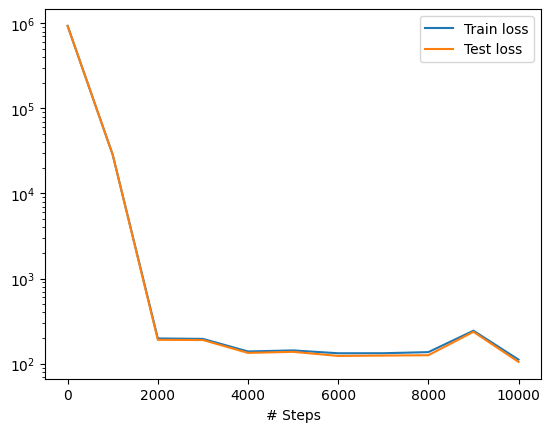

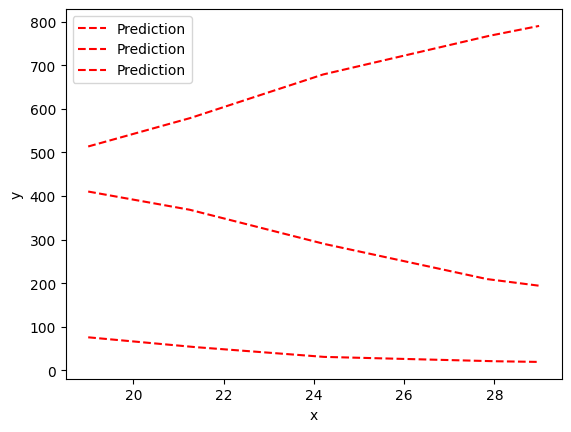

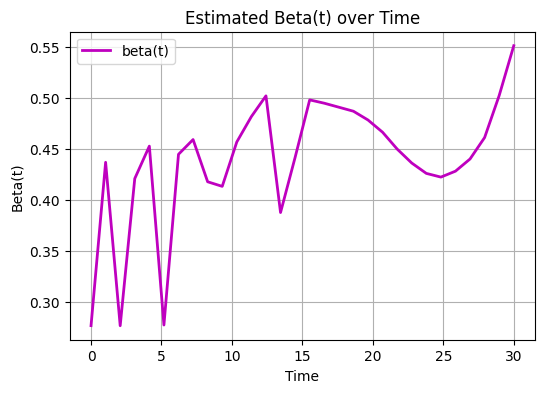

In [ ]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# Plot beta(t)
plt.figure(figsize=(6, 4))
plt.plot(t_data, beta_pred, 'm-', label='beta(t)', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Beta(t)")
plt.title("Estimated Beta(t) over Time")
plt.legend()
plt.grid(True)
plt.show()